# Engagement outcomes

For the primary and some secondary outcomes, we need to use Google Analytics page views data:

## E1: Number of page views over one month on CCG page showing low-priority measures

Timepoints: 
- 1 month before/after
- April-Sept 2018 vs April-Sept 2019

**Analytics data extraction procedure:**

`Analytics - Behaviour - Site Content - All Pages`
 
 ```
ADVANCED SEARCH: Page matching regexp "/ccg"  AND  Matching regexp "lowp" AND Exclude page including "analyse"
 SECONDARY DIMENSION: "DATE"
 DATE RANGE: Sept 2018 - Jan 2019 (visits take place Oct-Dec 2018); also April-Sept 2018 and April-Sept 2019
 SHOW ROWS: 5000
 ```
 Export as CSV
 Before importing, tidy up the csv to create a flat table
 (remove top and bottom groups of rows, convert numerical data to general format to remove commas)
 
## E2: Number of page views over one month on practice pages showing low-priority measures, grouped up to CCGs

Timepoints: 
- 1 month before/after
- April-Sept 2018 vs April-Sept 2019

 
**Analytics data extraction procedure:**
`Analytics - Behaviour - Site Content - All Pages`
 
 ```
ADVANCED SEARCH: Page matching regexp "/practice"  AND  Matching regexp "lowp" AND Exclude page including "analyse"
 SECONDARY DIMENSION: "DATE"
 DATE RANGE: Sept 2018 - Jan 2019 (visits take place Oct-Dec 2018); also April-Sept 2018 and April-Sept 2019
 SHOW ROWS: 5000
 ```
 
 Export as CSV

 Before importing, tidy up the csv to create a flat table
 (remove top and bottom groups of rows, convert numerical data to general format to remove commas)


In [1]:
# Import page views data
import pandas as pd
import numpy as np

# CCG-level data:
df1 = pd.read_csv('page_views_dummy_ccg.csv',usecols={"Page","Date","Pageviews","Unique Pageviews"} )
# practice-level data:
dfp = pd.read_csv('page_views_dummy_practice.csv',usecols={"Page","Date","Pageviews","Unique Pageviews"} )

df1 = pd.concat([df1,dfp])
df1.head()

,Page,Date,Pageviews,Unique Pageviews
0,/ccg/02P/measures/?tags=lowpriority,20180918,23,1
1,/ccg/99Q/measures/?tags=lowpriority,20180926,22,4
2,/ccg/99P/measures/?tags=lowpriority,20180926,18,3
3,/ccg/04Q/lpzomnibus/,20181003,16,2
4,/ccg/10V/measures/?tags=lowpriority,20181005,16,1


In [2]:
# convert Date field to date format
df1["date"] = df1.Date.apply(str).str[:4] + '-' + df1.Date.apply(str).str[4:6] + '-' + df1.Date.apply(str).str[6:]
df1["date"] = pd.to_datetime(df1.date)
df1 = df1.drop("Date",axis=1)
df1 = df1.loc[df1.Page.str.contains("lowp")]
df1.head()

,Page,Pageviews,Unique Pageviews,date
0,/ccg/02P/measures/?tags=lowpriority,23,1,2018-09-18
1,/ccg/99Q/measures/?tags=lowpriority,22,4,2018-09-26
2,/ccg/99P/measures/?tags=lowpriority,18,3,2018-09-26
4,/ccg/10V/measures/?tags=lowpriority,16,1,2018-10-05
5,/ccg/99N/measures/?tags=lowpriority,13,1,2018-10-11


In [3]:
# extract ccg/practice code from path
df1["org_id"] = np.where(df1.Page.str.contains("ccg"),df1.Page.str.replace('/ccg/', '').str[:3],df1.Page.str.replace('/practice/', '').str[:6])
df1["org_type"] = np.where(df1.Page.str.contains("ccg"),"ccg",'practice')
df1.head()

,Page,Pageviews,Unique Pageviews,date,org_id,org_type
0,/ccg/02P/measures/?tags=lowpriority,23,1,2018-09-18,02P,ccg
1,/ccg/99Q/measures/?tags=lowpriority,22,4,2018-09-26,99Q,ccg
2,/ccg/99P/measures/?tags=lowpriority,18,3,2018-09-26,99P,ccg
4,/ccg/10V/measures/?tags=lowpriority,16,1,2018-10-05,10V,ccg
5,/ccg/99N/measures/?tags=lowpriority,13,1,2018-10-11,99N,ccg


In [4]:
GBQ_PROJECT_ID = '620265099307'

# import practice-CCG mapping
mapp = '''select distinct ccg_id, code
from `ebmdatalab.hscic.practices` 
where setting = 4 and status_code != 'C'
'''
mapp = pd.read_gbq(mapp, GBQ_PROJECT_ID, dialect='standard',verbose=False)

### import **allocated** CCGs
ccgs = pd.read_csv('randomisation_group.csv')
# import joint team information
team = pd.read_csv('joint_teams.csv')

# create map of ccgs to joint teams
ccgs = ccgs.merge(team,on="joint_team", how="left")
#fill blank ccg_ids from joint_id column
ccgs["pct_id"] = ccgs["ccg_id"].combine_first(ccgs["joint_id"])
ccgs = ccgs[["joint_id","allocation","pct_id"]]
ccgs.head()

,joint_id,allocation,pct_id
0,01X,con,01X
1,99K,con,99K
2,01J,con,01J
3,09W,con,09W
4,01V,I,01T


In [5]:
# map practices onto CCGs
map2 = ccgs[["pct_id"]].merge(mapp, left_on="pct_id", right_on ="ccg_id", how="left")
df2 = df1.merge(map2[["ccg_id","code"]], left_on="org_id",right_on="code", how="left").drop("code",axis=1)
df2.loc[df2.org_id.str.len()==3,"ccg_id"] =df2.org_id
df2.head()

,Page,Pageviews,Unique Pageviews,date,org_id,org_type,ccg_id
0,/ccg/02P/measures/?tags=lowpriority,23,1,2018-09-18,02P,ccg,02P
1,/ccg/99Q/measures/?tags=lowpriority,22,4,2018-09-26,99Q,ccg,99Q
2,/ccg/99P/measures/?tags=lowpriority,18,3,2018-09-26,99P,ccg,99P
3,/ccg/10V/measures/?tags=lowpriority,16,1,2018-10-05,10V,ccg,10V
4,/ccg/99N/measures/?tags=lowpriority,13,1,2018-10-11,99N,ccg,99N


In [6]:
# map CCGs onto joint teams
df3 = df2.reset_index()
df3 = ccgs.merge(df3, left_on="pct_id",right_on="ccg_id",how="left")
df3.head()


,joint_id,allocation,pct_id,index,Page,Pageviews,Unique Pageviews,date,org_id,org_type,ccg_id
0,01X,con,01X,17,/ccg/01X/measures/?tags=lowpriority,5,1,2018-10-13,01X,ccg,01X
1,01X,con,01X,86,/ccg/01X/measures/?tags=lowpriority,2,1,2018-08-23,01X,ccg,01X
2,01X,con,01X,227,/ccg/01X/measures/?tags=lowpriority,1,1,2018-08-09,01X,ccg,01X
3,01X,con,01X,1579,/practice/N83017/measures/?tags=lowpriority,1,1,2018-08-17,N83017,practice,01X
4,99K,con,99K,175,/ccg/99K/measures/?tags=lowpriority,2,1,2018-09-06,99K,ccg,99K


In [7]:
GBQ_PROJECT_ID = '620265099307'

# import CCG population sizes
p = '''select pct_id, sum(total_list_size) as list_size
from `hscic.practice_statistics` as stats 
where CAST(month AS DATE) = '2018-08-01' -- latest available -- change to October for final analysis
group by pct_id
'''

pop = pd.read_gbq(p, GBQ_PROJECT_ID, dialect='standard',verbose=False)

# merge ccgs with population data
p2 = ccgs.merge(pop, on="pct_id",how="left")

# group up to joint teams
p2 = p2.groupby("joint_id").sum().reset_index()

p2.head()

,joint_id,list_size
0,00J,258773
1,00Y,256146
2,01F,131772
3,01J,165657
4,01V,280649


In [8]:
# import dates of interventions
dates = pd.read_csv('allocated_ccgs_visit_timetable.csv')
dates["date"] = pd.to_datetime(dates.date)
#merge with ccgs/joint teams
dts = ccgs.merge(dates, on="joint_id",how="left").drop("pct_id",axis=1).drop_duplicates()

# merge dates with list sizes 
dts = dts.merge(p2, on="joint_id")
dts["size_rank"] = dts.groupby("allocation").list_size.rank()

#assign dummy intervention dates to control practices by pairing on total list size 
i_group = dts[["allocation","date","size_rank"]].loc[dts.allocation=="I"].drop("allocation",axis=1)

dts = dts.merge(i_group, on= "size_rank", how="left", suffixes=["","_int"]).drop("date",axis=1).sort_values(by=["size_rank","allocation"])
dts.head()

,joint_id,allocation,list_size,size_rank,date_int
22,05V,I,149403,1.0,2018-09-17
14,02G,con,113244,1.0,2018-09-17
23,03E,I,163530,2.0,2018-10-09
39,10D,con,113816,2.0,2018-10-09
8,05G,I,217452,3.0,2018-09-20


In [9]:
# join allocated CCGs and visit dates to page views data
m = dts.drop("size_rank",axis=1).merge(df3.drop(["allocation","pct_id","ccg_id","index"],axis=1), how='left', on='joint_id')

m.head(9)

,joint_id,allocation,list_size,date_int,Page,Pageviews,Unique Pageviews,date,org_id,org_type
0,05V,I,149403,2018-09-17,/practice/M83045/measures/?tags=lowpriority,2,2,2018-10-12,M83045,practice
1,05V,I,149403,2018-09-17,/practice/M83024/measures/?tags=lowpriority,1,1,2018-10-12,M83024,practice
2,05V,I,149403,2018-09-17,/practice/M83044/measures/?tags=lowpriority,1,1,2018-10-04,M83044,practice
3,05V,I,149403,2018-09-17,/practice/M83045/measures/?tags=lowpriority,1,1,2018-10-17,M83045,practice
4,05V,I,149403,2018-09-17,/practice/M83052/measures/?tags=lowpriority,1,1,2018-10-12,M83052,practice
5,02G,con,113244,2018-09-17,/ccg/02G/measures/?tags=lowpriority,1,1,2018-09-27,02G,ccg
6,02G,con,113244,2018-09-17,/ccg/02G/measures/?tags=lowpriority,1,1,2018-09-28,02G,ccg
7,02G,con,113244,2018-09-17,/ccg/02G/measures/?tags=lowpriority,1,1,2018-10-04,02G,ccg
8,03E,I,163530,2018-10-09,/ccg/03E/measures/?tags=lowpriority,2,2,2018-08-09,03E,ccg


In [10]:
# assign each page view occurrence to before vs after intervention (1 month ~ 28 days)

m["datediff"] = m.date-m.date_int
m["timing"] = "none"
m.loc[(m.datediff<="28 days")&(m.datediff> "0 days"),"timing"] = "after"
m.loc[(m.datediff>="-28 days")&(m.datediff< "0 days"),"timing"] = "before"
m["Unique Pageviews"] =m["Unique Pageviews"].fillna(0)
m.head()

,joint_id,allocation,list_size,date_int,Page,Pageviews,Unique Pageviews,date,org_id,org_type,datediff,timing
0,05V,I,149403,2018-09-17,/practice/M83045/measures/?tags=lowpriority,2,2,2018-10-12,M83045,practice,25 days,after
1,05V,I,149403,2018-09-17,/practice/M83024/measures/?tags=lowpriority,1,1,2018-10-12,M83024,practice,25 days,after
2,05V,I,149403,2018-09-17,/practice/M83044/measures/?tags=lowpriority,1,1,2018-10-04,M83044,practice,17 days,after
3,05V,I,149403,2018-09-17,/practice/M83045/measures/?tags=lowpriority,1,1,2018-10-17,M83045,practice,30 days,none
4,05V,I,149403,2018-09-17,/practice/M83052/measures/?tags=lowpriority,1,1,2018-10-12,M83052,practice,25 days,after


In [11]:
# group up page views data to joint teams and sum page views before and after interventions

m2 = m.loc[m.timing!=""].groupby(["allocation","joint_id","org_type","list_size","timing"]).agg({"Unique Pageviews":sum,
                                                                                      "Page":"nunique"}).unstack().fillna(0)
m2 = m2.rename(columns={"Page":"No_of_Pages"}).reset_index()
#flatten columns and drop superfluous columns
m2.columns = m2.columns.map('_'.join)
m2 = m2.drop(["Unique Pageviews_none","No_of_Pages_none"], axis=1)
m2.head()

,allocation_,joint_id_,org_type_,list_size_,Unique Pageviews_after,Unique Pageviews_before,No_of_Pages_after,No_of_Pages_before
0,I,00J,ccg,258773,0.0,0.0,0.0,0.0
1,I,00J,practice,258773,2.0,0.0,1.0,0.0
2,I,01V,ccg,280649,1.0,1.0,1.0,1.0
3,I,01V,practice,280649,3.0,1.0,3.0,1.0
4,I,02P,ccg,261195,0.0,2.0,0.0,1.0


# Engagement outcome E1 #######################################################
## Number of page views over one month on CCG pages showing low-priority measures, before vs after intervention, between intervention and control groups. 


In [12]:
# filter CCG page views only:
m3 = m2.loc[m2.org_type_ == "ccg"]
m3.head()

,allocation_,joint_id_,org_type_,list_size_,Unique Pageviews_after,Unique Pageviews_before,No_of_Pages_after,No_of_Pages_before
0,I,00J,ccg,258773,0.0,0.0,0.0,0.0
2,I,01V,ccg,280649,1.0,1.0,1.0,1.0
4,I,02P,ccg,261195,0.0,2.0,0.0,1.0
7,I,03E,ccg,163530,0.0,2.0,0.0,1.0
9,I,03J,ccg,749327,0.0,2.0,0.0,2.0


In [13]:
# max-out top 5% to reduce any extreme outliers

mx = m3.copy()

max_out = mx['Unique Pageviews_before'].quantile(0.95)
m3["proxy_pageviews_before"] = np.where(m3['Unique Pageviews_before']<max_out, m3['Unique Pageviews_before'], max_out)

max_out_b = mx['Unique Pageviews_after'].quantile(0.95)
m3["proxy_pageviews_after"] = np.where(m3['Unique Pageviews_after']<max_out_b, m3['Unique Pageviews_after'], max_out_b)



result = pd.DataFrame({'Unique Pageviews_after': m3["Unique Pageviews_after"].describe(),
                       'Unique Pageviews_before': m3["Unique Pageviews_before"].describe(),
                       'Proxy_pageviews_after': m3["proxy_pageviews_after"].describe(),
                       'Proxy_pageviews_before': m3["proxy_pageviews_before"].describe()
                      })

result


C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Proxy_pageviews_after,Proxy_pageviews_before,Unique Pageviews_after,Unique Pageviews_before
count,33.000000,33.000000,33.000000,33.000000
mean,1.175758,1.000000,1.666667,1.030303
std,1.511421,0.829156,3.593976,0.883348
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000
75%,2.000000,2.000000,2.000000,2.000000
max,4.400000,2.000000,20.000000,3.000000


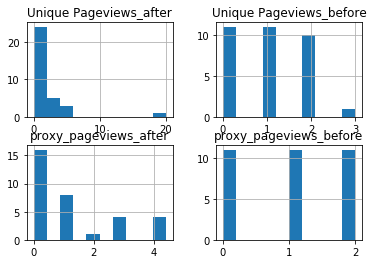

In [14]:
#visualise data and proxy data

import matplotlib.pyplot as plt

m3[["proxy_pageviews_after","proxy_pageviews_before","Unique Pageviews_after","Unique Pageviews_before"]].hist(bins=10)
plt.show()


In [15]:
m4 = m3.groupby(["allocation_"])['proxy_pageviews_before','proxy_pageviews_after'].mean()

m4

,proxy_pageviews_before,proxy_pageviews_after
allocation_,,
I,1.062500,1.275000
con,0.941176,1.082353


### Statistical analysis

In [16]:

import statsmodels.formula.api as smf
data = m3.copy()
# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation_.map({'con':0, 'I':1})

lm = smf.ols(formula='data["proxy_pageviews_after"] ~ data["proxy_pageviews_before"] +intervention', data=data).fit()

#output regression coefficients and p-values:
params = pd.DataFrame(lm.params).reset_index().rename(columns={0: 'coefficient','index': 'factor'})
pvals = pd.DataFrame(lm.pvalues[[1,2]]).reset_index().rename(columns={0: 'p value','index': 'factor'})
params.merge(pvals, how='left',on='factor').set_index('factor').reset_index()

,factor,coefficient,p value
0,Intercept,1.477802,NaN
1,"data[""proxy_pageviews_before""]",-0.420165,0.204681
2,intervention,0.243623,0.648730


In [17]:
# confidence intervals
lm.conf_int().loc["intervention"]

0   -0.837656
1    1.324902
Name: intervention, dtype: float64

# Engagement outcome E2
## Number of page views over one month on practice pages showing low-priority measures, before vs after intervention, grouped up to CCGs, between intervention and control groups. 

In [18]:
# filter practice page views only:
m5 = m2.loc[m2.org_type_ == "practice"]
m5.head()

,allocation_,joint_id_,org_type_,list_size_,Unique Pageviews_after,Unique Pageviews_before,No_of_Pages_after,No_of_Pages_before
1,I,00J,practice,258773,2.0,0.0,1.0,0.0
3,I,01V,practice,280649,3.0,1.0,3.0,1.0
5,I,02P,practice,261195,1.0,1.0,1.0,1.0
6,I,02X,practice,321704,2.0,5.0,1.0,3.0
8,I,03E,practice,163530,0.0,2.0,0.0,2.0


In [19]:
# max-out top 5% to reduce extreme outliers

mx = m5.copy()

max_out = mx['Unique Pageviews_before'].quantile(0.95)
m5["proxy_pageviews_before"] = np.where(m5['Unique Pageviews_before']<max_out, m5['Unique Pageviews_before'], max_out)

max_out_b = mx['Unique Pageviews_after'].quantile(0.95)
m5["proxy_pageviews_after"] = np.where(m5['Unique Pageviews_after']<max_out_b, m5['Unique Pageviews_after'], max_out_b)

result = pd.DataFrame({'Unique Pageviews_after': m5["Unique Pageviews_after"].describe(),
                       'Unique Pageviews_before': m5["Unique Pageviews_before"].describe(),
                       'Proxy_pageviews_after': m5["proxy_pageviews_after"].describe(),
                       'Proxy_pageviews_before': m5["proxy_pageviews_before"].describe()
                      })

result


C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Proxy_pageviews_after,Proxy_pageviews_before,Unique Pageviews_after,Unique Pageviews_before
count,39.000000,39.000000,39.000000,39.000000
mean,2.282051,1.461538,2.307692,1.487179
std,2.383592,1.484058,2.451142,1.553803
min,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.500000,0.000000
50%,2.000000,1.000000,2.000000,1.000000
75%,3.000000,2.000000,3.000000,2.000000
max,8.000000,5.000000,9.000000,6.000000


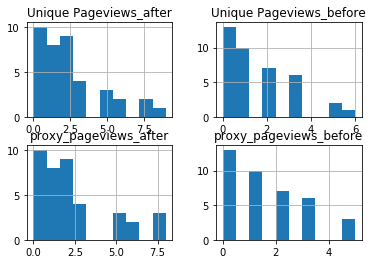

In [20]:
import matplotlib.pyplot as plt

m5[["proxy_pageviews_after","proxy_pageviews_before","Unique Pageviews_after","Unique Pageviews_before"]].hist(bins=10)
plt.show()


In [21]:
m5.groupby(["allocation_"])['proxy_pageviews_before','proxy_pageviews_after'].mean()


,proxy_pageviews_before,proxy_pageviews_after
allocation_,,
I,1.650000,2.250000
con,1.263158,2.315789


### Statistical analysis

In [22]:

import statsmodels.formula.api as smf
data = m5
# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation_.map({'con':0, 'I':1})

lm = smf.ols(formula='data["proxy_pageviews_after"] ~ data["proxy_pageviews_before"] +intervention', data=data).fit()

#output regression coefficients and p-values:
params = pd.DataFrame(lm.params).reset_index().rename(columns={0: 'coefficient','index': 'factor'})
pvals = pd.DataFrame(lm.pvalues[[1,2]]).reset_index().rename(columns={0: 'p value','index': 'factor'})
params.merge(pvals, how='left',on='factor').set_index('factor')

C:\Users\hcurtis\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,coefficient,p value
factor,,
Intercept,1.836987,NaN
"data[""proxy_pageviews_before""]",0.379052,0.157431
intervention,-0.212423,0.784064


In [23]:
#confidence intervals
lm.conf_int().loc["intervention"]

0   -1.772878
1    1.348032
Name: intervention, dtype: float64

# Engagement outcomes E3 and E4 : Alert sign-ups
## E3 Number of registrations to OpenPrescribing CCG email alerts 
## E4 Number of registrations to OpenPrescribing Practice email alerts grouped up to CCG
(New sign-ups within 3 months of intervention. The CCG registered population and number of sign-ups prior to the intervention will be co-variables.)

In [24]:
#import data from django administration, filtered for confirmed sign-ups only (no date filter)

alerts = pd.read_csv('OrgBookmark-2018-11-02.csv')
alerts["created_at"] = pd.to_datetime(alerts.created_at)
alerts.head()

,id,user,pct,practice,created_at,approved
0,2333,2815,00C,NaN,2018-11-02 09:23:07,1
1,2331,2813,NaN,P81770,2018-11-01 13:00:49,1
2,2330,2569,NaN,J82102,2018-11-01 11:23:36,1
3,2329,2783,NaN,N81087,2018-10-31 16:17:25,1
4,2327,2809,NaN,J83029,2018-10-31 09:39:51,1


In [25]:
# map practices to joint teams (only included randomised CCGs)
a2 = alerts.merge(map2[["ccg_id","code"]], left_on="practice",right_on="code", how="left").drop("code",axis=1)
a2.ccg_id = a2.ccg_id.combine_first(a2.pct)
a2.head()

,id,user,pct,practice,created_at,approved,ccg_id
0,2333,2815,00C,NaN,2018-11-02 09:23:07,1,00C
1,2331,2813,NaN,P81770,2018-11-01 13:00:49,1,NaN
2,2330,2569,NaN,J82102,2018-11-01 11:23:36,1,NaN
3,2329,2783,NaN,N81087,2018-10-31 16:17:25,1,NaN
4,2327,2809,NaN,J83029,2018-10-31 09:39:51,1,NaN


In [26]:
# merge ccgs with data
a3 = a2.copy()
a3 = ccgs.merge(a3, left_on="pct_id",right_on="ccg_id",how="left")
a3.head()


,joint_id,allocation,pct_id,id,user,pct,practice,created_at,approved,ccg_id
0,01X,con,01X,1615.0,2042.0,01X,NaN,2018-04-27 10:11:30,1.0,01X
1,01X,con,01X,799.0,997.0,NaN,N83060,2017-10-02 11:03:46,1.0,01X
2,99K,con,99K,1933.0,2481.0,99K,NaN,2018-07-25 08:45:38,1.0,99K
3,99K,con,99K,1753.0,2243.0,99K,NaN,2018-06-07 09:48:30,1.0,99K
4,99K,con,99K,1562.0,1984.0,NaN,G81100,2018-04-22 10:28:17,1.0,99K


In [27]:
# join to visit dates
a4 = dts.drop(["size_rank","allocation"],axis=1).merge(a3.drop(["approved"],axis=1), how='left', on='joint_id')
a4.head()

,joint_id,list_size,date_int,allocation,pct_id,id,user,pct,practice,created_at,ccg_id
0,05V,149403,2018-09-17,I,05V,NaN,NaN,NaN,NaN,NaT,NaN
1,02G,113244,2018-09-17,con,02G,2144.0,2658.0,02G,NaN,2018-09-27 17:58:16,02G
2,02G,113244,2018-09-17,con,02G,686.0,864.0,02G,NaN,2017-08-17 08:30:02,02G
3,03E,163530,2018-10-09,I,03E,1407.0,1782.0,NaN,B82030,2018-03-05 20:49:26,03E
4,03E,163530,2018-10-09,I,03E,1254.0,1558.0,NaN,B82027,2018-01-23 15:04:58,03E


In [28]:
# assign each sign up to before vs after intervention (anytime before vs 3 months afterwards. 1 month ~ 28 days)
a5 = a4.copy()
a5["datediff"] = a5.created_at-a5.date_int
a5["timing"] = "none"
# all alerts set up prior to day of intervention will be used as a co-variable:
a5.loc[(a5.datediff< "0 days"),"timing"] = "before"
# main outcome: alerts set up within 3 months of intervention:
a5.loc[(a5.datediff>= "0 days")& (a5.datediff<= "84 days"),"timing"] = "after"  #(within 3 months)

# flag whether each alert is a practice or CCG alert
conditions = [
    (a5.pct.str.len()==3),
    (a5.practice.str.len()==6)]

choices = ['ccg', 'practice']
a5['org_type'] = np.select(conditions, choices, default='none')
a5.head()

,joint_id,list_size,date_int,allocation,pct_id,id,user,pct,practice,created_at,ccg_id,datediff,timing,org_type
0,05V,149403,2018-09-17,I,05V,NaN,NaN,NaN,NaN,NaT,NaN,NaT,none,none
1,02G,113244,2018-09-17,con,02G,2144.0,2658.0,02G,NaN,2018-09-27 17:58:16,02G,10 days 17:58:16,after,ccg
2,02G,113244,2018-09-17,con,02G,686.0,864.0,02G,NaN,2017-08-17 08:30:02,02G,-396 days +08:30:02,before,ccg
3,03E,163530,2018-10-09,I,03E,1407.0,1782.0,NaN,B82030,2018-03-05 20:49:26,03E,-218 days +20:49:26,before,practice
4,03E,163530,2018-10-09,I,03E,1254.0,1558.0,NaN,B82027,2018-01-23 15:04:58,03E,-259 days +15:04:58,before,practice


In [30]:
# aggregate data: sum alerts before and after intervention for each joint team

a6 = a5.groupby(["allocation","joint_id","list_size","timing","org_type"]).agg({"user":"nunique"}).unstack().fillna(0)
a6 = a6.rename(columns={"user":"alerts"}).unstack().reset_index().fillna(0)
#flatten columns:
a6.columns = a6.columns.map('_'.join)

a6["list_size_100k"] = a6["list_size__"]/100000
a6 = a6[["allocation__","joint_id__","list_size_100k","alerts_ccg_after","alerts_ccg_before","alerts_practice_after","alerts_practice_before"]]
a6 = a6.rename(columns={"allocation__":"allocation","joint_id__":"joint_id"})

a6.head()

,allocation,joint_id,list_size_100k,alerts_ccg_after,alerts_ccg_before,alerts_practice_after,alerts_practice_before
0,I,00J,2.58773,0.0,0.0,0.0,1.0
1,I,01V,2.80649,0.0,0.0,0.0,7.0
2,I,02P,2.61195,0.0,0.0,0.0,1.0
3,I,02X,3.21704,0.0,0.0,0.0,3.0
4,I,03E,1.63530,0.0,1.0,0.0,3.0


In [31]:
# summary data
a6.groupby("allocation").mean()

,list_size_100k,alerts_ccg_after,alerts_ccg_before,alerts_practice_after,alerts_practice_before
allocation,,,,,
I,3.318947,0.10,1.5,0.15,4.1
con,2.595924,0.15,2.4,0.20,2.2


### E3: CCG alert sign-ups

In [32]:
import statsmodels.formula.api as smf
data = a6.copy()

# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

lm = smf.ols(formula='data["alerts_ccg_after"] ~ data["alerts_ccg_before"]+ data["list_size_100k"] +intervention', data=data).fit()

#output regression coefficients and p-values:
params = pd.DataFrame(lm.params).reset_index().rename(columns={0: 'coefficient','index': 'factor'})
pvals = pd.DataFrame(lm.pvalues[[1,2]]).reset_index().rename(columns={0: 'p value','index': 'factor'})
params.merge(pvals, how='left',on='factor').set_index('factor')

,coefficient,p value
factor,,
Intercept,0.146551,NaN
"data[""alerts_ccg_before""]",-0.036700,0.255036
"data[""list_size_100k""]",0.035258,0.481780
intervention,-0.108522,NaN


In [33]:
# confidence intervals
lm.conf_int().loc["intervention"]

0   -0.356804
1    0.139759
Name: intervention, dtype: float64

### E4: practice alert sign-ups

In [34]:
import statsmodels.formula.api as smf
data = a6.copy()

# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

lm = smf.ols(formula='data["alerts_practice_after"] ~ data["alerts_practice_before"] + data["list_size_100k"] + intervention', data=data).fit()

#output regression coefficients and p-values:
params = pd.DataFrame(lm.params).reset_index().rename(columns={0: 'coefficient','index': 'factor'})
pvals = pd.DataFrame(lm.pvalues[[1,2]]).reset_index().rename(columns={0: 'p value','index': 'factor'})
params.merge(pvals, how='left',on='factor').set_index('factor')

,coefficient,p value
factor,,
Intercept,0.243150,NaN
"data[""alerts_practice_before""]",0.036423,0.212792
"data[""list_size_100k""]",-0.047490,0.460147
intervention,-0.084867,NaN


In [35]:
# confidence intervals
lm.conf_int().loc["intervention"]

0   -0.391637
1    0.221902
Name: intervention, dtype: float64